<a href="https://colab.research.google.com/github/puneat/Audio_Sentiment/blob/puneet/Male_Augmented_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
from tqdm import tqdm
import pickle
import IPython.display as ipd  # To play sound in the notebook

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
df=pd.read_csv('/gdrive/My Drive/Audio_files/Combined_Dataframes/augmented_male.csv')

In [7]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.20
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

#data before normalisation 
X_train[150:160]

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
22678,2158,-19.770191,-17.820446,-17.172469,-14.361007,-14.878365,-16.168246,-15.969766,-16.005413,-17.098746,-15.539544,-13.998212,-13.713506,-11.750972,-11.701815,-12.895173,-13.193752,-15.526430,-15.676518,-14.067893,-15.472958,-16.528864,-15.441254,-12.279467,-10.657224,-11.357713,-10.613318,-10.325374,-10.473237,-11.301556,-12.757654,-12.554570,-12.212356,-15.036889,-17.622550,-15.972091,-14.625575,-14.088717,-13.612458,-14.789350,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
27102,1452,-18.470215,-18.634213,-17.348700,-15.328758,-15.381434,-14.881728,-14.212455,-12.226182,-11.949044,-12.550916,-14.027365,-15.693438,-15.010396,-15.579869,-15.537688,-15.171172,-13.359892,-12.793194,-13.889895,-13.812256,-12.941505,-14.517511,-16.258690,-15.755478,-14.633683,-15.841612,-14.836003,-14.990748,-14.909520,-12.901282,-12.355986,-12.152347,-11.830311,-10.616625,-11.080653,-12.363033,-12.449130,-11.009433,-12.825597,...,-39.570224,-39.570224,-39.570224,-39.570224,-39.570224,-39.570224,-39.570224,-39.570224,-39.570224,-39.570224,-39.570224,-39.570224,-39.570224,-39.570224,-39.570224,-28.874165,-19.419418,-16.332369,-17.411228,-16.866331,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3584,3584,-3.463185,-7.545588,-14.848887,-15.441847,-15.028918,-14.971291,-14.269434,-14.801823,-16.023823,-15.481306,-8.427888,-7.484760,-13.050666,-10.841432,-10.418455,-10.521139,-7.367857,-4.449355,-5.866468,-12.711026,-13.946189,-14.309726,-12.547684,-12.579071,-15.594072,-18.169230,-15.468671,-17.139344,-17.015953,-16.487126,-19.304447,-17.789947,-14.430106,-15.071532,-14.002765,-13.830706,-13.733434,-10.537228,-9.873762,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1888,1888,-23.718474,-20.618072,-17.807260,-19.064650,-17.800028,-16.130265,-15.282562,-11.925191,-12.580800,-12.265557,-11.412405,-10.974491,-10.423262,-11.200537,-11.334430,-11.781767,-11.962812,-12.664647,-14.975012,-17.376903,-17.249843,-17.091736,-17.923140,-13.648929,-12.432248,-11.585258,-12.116064,-14.541969,-18.015712,-17.273672,-17.688054,-17.970072,-18.072219,-17.098370,-13.962287,-15.191273,-18.920876,-18.606639,-17.700299,...,-18.403998,-17.395160,-17.217328,-18.674013,-20.092665,-19.631804,-20.346772,-22.052234,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7138,2008,1.776653,-1.903978,-12.248746,-10.059386,-9.470712,-8.762602,-11.207290,-12.512509,-13.232669,-13.550707,-11.436189,-12.119967,-12.320873,-14.536313,-15.901869,-14.237517,-13.315524,-15.105322,-16.199096,-14.231690,-10.130239,-9.654405,-7.975957,-6.780436,-6.441665,-5.973769,-7.497015,-6.825514,-8.094548,-10.180581,-9.898857,-10.754988,-10.999878,-11.198864,-9.463021,-9.427083,-10.461188,-7.400341,-7.110035,...,-17.300394,-15.908964,-14.0240

In [8]:
# data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
22678,-0.271252,0.168684,0.269982,0.357674,0.522608,0.471682,0.371220,0.367803,0.350646,0.257892,0.354622,0.457073,0.473369,0.603617,0.601362,0.514713,0.493808,0.330045,0.318789,0.427737,0.327729,0.250236,0.323535,0.543235,0.658744,0.609691,0.663989,0.685690,0.676454,0.617028,0.505549,0.519892,0.547261,0.303226,0.067993,0.205820,0.324208,0.371506,0.420494,0.305310,...,0.895429,0.899126,0.903580,0.873929,0.876673,0.879624,0.851324,0.852089,0.826121,0.826834,0.826852,0.802512,0.801175,0.800675,0.773668,0.773595,0.772818,0.751099,0.750453,0.751024,0.731834,0.731721,0.731378,0.714556,0.714996,0.714067,0.691246,0.691590,0.692605,0.671934,0.671300,0.651529,0.650073,0.649610,0.630316,0.629083,0.629010,0.614118,0.609028,0.605407
27102,-0.747240,0.244682,0.220788,0.346532,0.460782,0.439069,0.455779,0.485186,0.607414,0.614291,0.562405,0.455044,0.335497,0.377136,0.331816,0.330899,0.356020,0.481292,0.520249,0.440181,0.444031,0.501741,0.388443,0.262964,0.297632,0.375768,0.286544,0.355963,0.341793,0.344018,0.494345,0.535904,0.552268,0.580210,0.693799,0.656872,0.538620,0.530656,0.677042,0.501449,...,-0.719947,-0.709772,-0.699310,-0.726850,-0.718438,-0.710688,-0.741060,-0.739054,-0.768456,-0.767533,-0.767299,-0.798283,-0.798926,-0.798968,-0.833700,-0.399762,-0.016640,0.083214,0.038042,0.060930,0.731834,0.731721,0.731378,0.714556,0.714996,0.714067,0.691246,0.691590,0.692605,0.671934,0.671300,0.651529,0.650073,0.649610,0.630316,0.629083,0.629010,0.614118,0.609028,0.605407
3584,0.690163,1.122015,0.891119,0.504571,0.453558,0.461922,0.449892,0.481380,0.432420,0.332285,0.358671,0.844755,0.907107,0.513308,0.661164,0.686994,0.680038,0.899600,1.103239,1.001079,0.521151,0.431304,0.403043,0.524344,0.522618,0.307191,0.118507,0.309715,0.182623,0.184627,0.214621,-0.024354,0.081889,0.355640,0.295863,0.387416,0.399534,0.405992,0.723581,0.796279,...,0.895429,0.899126,0.903580,0.873929,0.876673,0.879624,0.851324,0.852089,0.826121,0.826834,0.826852,0.802512,0.801175,0.800675,0.773668,0.773595,0.772818,0.751099,0.750453,0.751024,0.731834,0.731721,0.731378,0.714556,0.714996,0.714067,0.691246,0.691590,0.692605,0.671934,0.671300,0.651529,0.650073,0.649610,0.630316,0.629083,0.629010,0.614118,0.609028,0.605407
1888,-0.453287,-0.062138,0.100859,0.317542,0.222112,0.282278,0.373717,0.413706,0.627864,0.570568,0.582244,0.637039,0.664100,0.695874,0.636204,0.623278,0.592197,0.578823,0.529230,0.364323,0.194393,0.199689,0.207561,0.145731,0.446840,0.532963,0.593822,0.554791,0.375039,0.108977,0.153264,0.105977,0.066860,0.041034,0.114815,0.391149,0.270599,-0.097538,-0.071720,0.014564,...,0.144123,0.191851,0.206149,0.118488,0.066720,0.090629,0.032530,-0.034645,0.826121,0.826834,0.826852,0.802512,0.801175,0.800675,0.773668,0.773595,0.772818,0.751099,0.750453,0.751024,0.731834,0.731721,0.731378,0.714556,0.714996,0.714067,0.691246,0.691590,0.692605,0.671934,0.671300,0.651529,0.650073,0.649610,0.630316,0.629083,0.629010,0.614118,0.609028,0.605407
7138,-0.372383,1.428343,1.232166,0.668953,0.797420,0.822246,0.857970,0.685923,0.587961,0.525454,0.492895,0.635384,0.584335,0.564018,0.404349,0.305566,0.421078,0.484389,0.358699,0.278750,0.414657,0.698835,0.730156,0.846347,0.933338,0.960726,0.998930,0.892443,0.946680,0.859697,0.706582,0.734024,0.668858,0.651943,0.641790,0.806038,0.816847,0.723619,1.032745,1.072320,...,0.189175,0.252278,0.335502,0.324467,0.236228,0.270026,0.169834,0.214228,0.222803,0.207027,0.198418,0.155155,0.111810,-0.024537,0.773668,0.773595,0.772818,0.751099,0.750453,0.751024,0.731834,0.731721,0.731378,0.714556,0.714996,0.714067,0.691246,0.691590,0.692605,0.671934,0.671300,0.651529,0.650073,0.649610,0.630316,0.629083,0.629010,0.614118,0.609028,0.605407
13134,0.211478,0.262792,0.321442,0.392761,0

In [9]:
#steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(24624, 217)
['male_angry' 'male_disgust' 'male_fear' 'male_happy' 'male_neutral'
 'male_sad' 'male_surprise']


In [10]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(24624, 217, 1)

In [33]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(128)) # Target class number
model.add(Activation('relu'))
model.add(Dense(128)) # Target class number
model.add(Activation('relu'))
model.add(Dense(128)) # Target class number
model.add(Activation('relu'))
model.add(Dense(128)) # Target class number
model.add(Activation('relu'))
model.add(Dense(7)) # Target class number
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 217, 256)          2304      
_________________________________________________________________
activation_25 (Activation)   (None, 217, 256)          0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 217, 256)          524544    
_________________________________________________________________
batch_normalization_5 (Batch (None, 217, 256)          1024      
_________________________________________________________________
activation_26 (Activation)   (None, 217, 256)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 217, 256)          0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 27, 256)          

In [34]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=10, epochs=200, validation_data=(X_test, y_test),verbose=1)

Train on 24624 samples, validate on 6156 samples
Epoch 1/200
24624/24624 [==============================] - 36s 1ms/step - loss: 1.7815 - accuracy: 0.2564 - val_loss: 1.7186 - val_accuracy: 0.3012
Epoch 2/200
24624/24624 [==============================] - 35s 1ms/step - loss: 1.6872 - accuracy: 0.3136 - val_loss: 1.6998 - val_accuracy: 0.3127
Epoch 3/200
24624/24624 [==============================] - 35s 1ms/step - loss: 1.6577 - accuracy: 0.3280 - val_loss: 1.6512 - val_accuracy: 0.3345
Epoch 4/200
24624/24624 [==============================] - 35s 1ms/step - loss: 1.6343 - accuracy: 0.3402 - val_loss: 1.6951 - val_accuracy: 0.3002
Epoch 5/200
24624/24624 [==============================] - 35s 1ms/step - loss: 1.6124 - accuracy: 0.3490 - val_loss: 1.6546 - val_accuracy: 0.3324
Epoch 6/200
24624/24624 [==============================] - 35s 1ms/step - loss: 1.5935 - accuracy: 0.3581 - val_loss: 1.6297 - val_accuracy: 0.3441
Epoch 7/200
24624/24624 [==============================] - 35s 

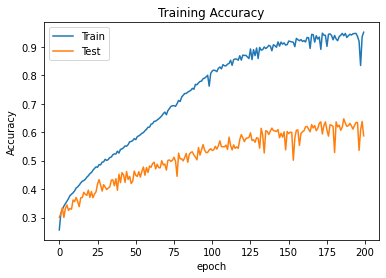

In [36]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [37]:
# Save model and weights
model_name = 'male_cnn1d_aug_exp.h5'
model_path='/gdrive/My Drive/Audio_files/saved_models/'


model.save(model_path+model_name)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open((model_path+"male_cnn1d_aug_exp.json"), "w") as json_file:
    json_file.write(model_json)

Save model and weights at /gdrive/My Drive/Audio_files/saved_models/ 


In [38]:
# loading json and model architecture 
model_path='/gdrive/My Drive/Audio_files/saved_models/'
json_file = open((model_path+'male_cnn1d_aug_exp.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights((model_path+"male_cnn1d_aug_exp.h5"))
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 58.69%


In [27]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

6156/6156 [==============================] - 2s 326us/step


array([3, 4, 5, ..., 4, 6, 2])

In [28]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,male_sad,male_sad
171,male_happy,male_happy
172,male_happy,male_happy
173,male_fear,male_happy
174,male_fear,male_fear
175,male_fear,male_happy
176,male_happy,male_happy
177,male_angry,male_angry
178,male_angry,male_disgust
179,male_sad,male_sad


In [29]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
male_angry,743
male_disgust,1085
male_fear,864
male_happy,1269
male_neutral,1019
male_sad,1025
male_surprise,151


In [30]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

0.6647173489278753


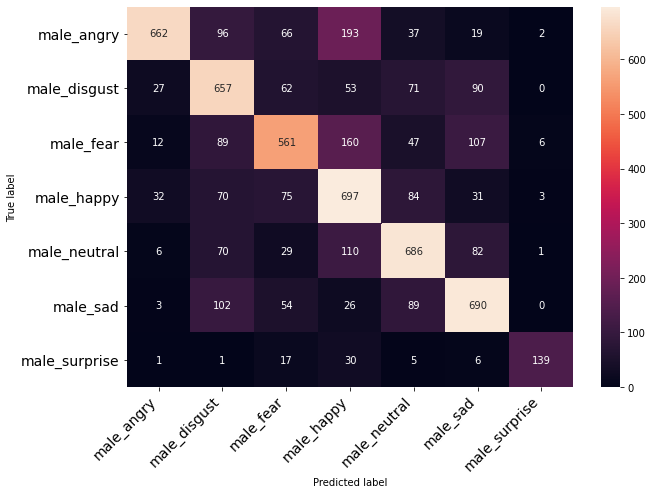

In [31]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [32]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

               precision    recall  f1-score   support

   male_angry       0.89      0.62      0.73      1075
 male_disgust       0.61      0.68      0.64       960
    male_fear       0.65      0.57      0.61       982
   male_happy       0.55      0.70      0.62       992
 male_neutral       0.67      0.70      0.68       984
     male_sad       0.67      0.72      0.69       964
male_surprise       0.92      0.70      0.79       199

     accuracy                           0.66      6156
    macro avg       0.71      0.67      0.68      6156
 weighted avg       0.68      0.66      0.67      6156



In [42]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
from keras.utils import plot_model
from keras.models import Sequential
np.random.seed(4)
from keras.layers import LeakyReLU


adam = optimizers.Adam(lr=0.0005)


from keras.layers import LeakyReLU
# now add a ReLU layer explicitly:

model_3 = Sequential()
model_3.add(LSTM(32, return_sequences=True,activation='relu', input_shape=(X_train.shape[1],1)))
#model_3.add(LeakyReLU(alpha=0.0001))
#model_3.add(LSTM(5 ,return_sequences=True, activation='relu'))
#model_3.add(LeakyReLU(alpha=0.0001))
model_3.add(LSTM(32, activation='relu'))
#model_3.add(LeakyReLU(alpha=0.0001))
model_3.add(Dense(7,activation = 'softmax'))  # return a single vector of dimension 32
model_3.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])
#plot_model(model_3, to_file='model_3.png')




In [43]:
history_3=model_3.fit(x=X_train, y=y_train, batch_size=50, epochs=100 , shuffle=True, validation_data=(X_test, y_test),verbose=1)
evaluation_3 = model_3.evaluate(X_test, y_test)
# serialize model to JSON


Train on 24624 samples, validate on 6156 samples
Epoch 1/100
16650/24624 [===================>..........] - ETA: 1:45 - loss: 5832591.7255 - acc: 0.1664

KeyboardInterrupt: ignored